In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

In [2]:
X, y = (load_breast_cancer(return_X_y=True, as_frame=True))
X = pd.DataFrame((X["mean concave points"], X["worst area"])).T
print(X.head())
print("\n Target values =", set(y))

   mean concave points  worst area
0              0.14710      2019.0
1              0.07017      1956.0
2              0.12790      1709.0
3              0.10520       567.7
4              0.10430      1575.0

 Target values = {0, 1}


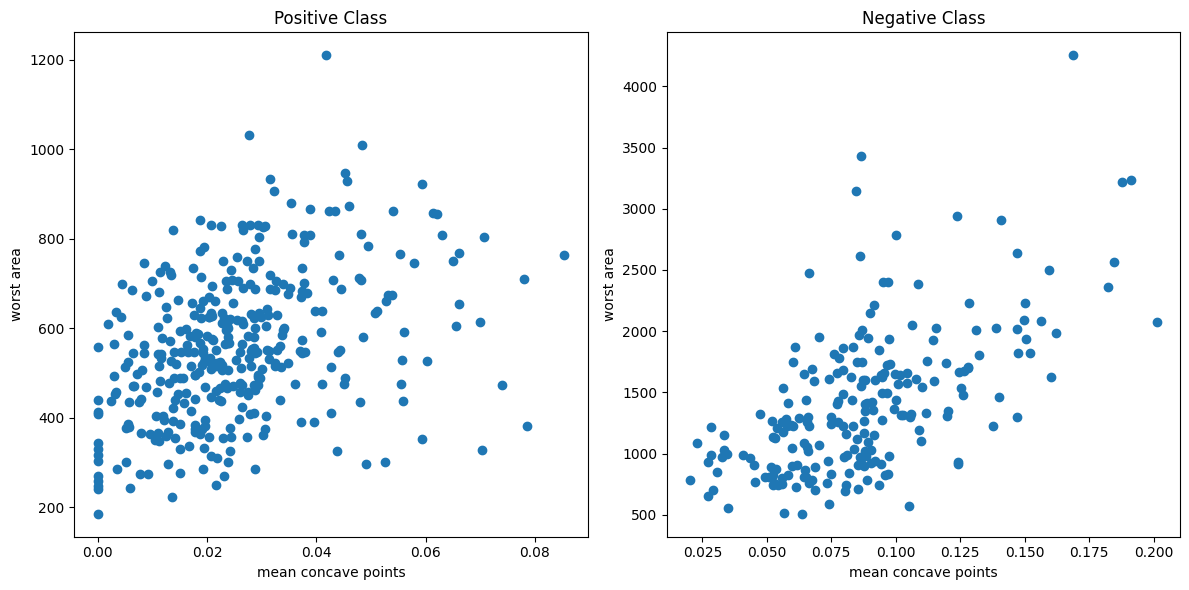

In [3]:
plt.figure(figsize=(12, 6)) 
plt.subplot(1, 2, 1)
plt.title("Positive Class")
plt.xlabel("mean concave points")
plt.ylabel("worst area")
plt.scatter(X["mean concave points"][y==1], X["worst area"][y==1])
plt.subplot(1, 2, 2)
plt.title("Negative Class")
plt.xlabel("mean concave points")
plt.ylabel("worst area")
plt.scatter(X["mean concave points"][y==0], X["worst area"][y==0])
plt.tight_layout()
plt.show()

Both worst area and mean concave points take larger values in the negative class ($\approx$ 2-3 times larger).

We scale the data and then we create two support vector machine classifiers, one with C=0.1 and one with C=1000

In [4]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

In [5]:
svc1 = SVC(kernel="linear", C=0.1, random_state=42)
svc2 = SVC(kernel="linear", C=1000, random_state=42)

We fit the two classifiers to the data and plot the data points, the decision boundaries and the margins for the two classifiers.

In [6]:
svc1.fit(X_sc, y)
svc2.fit(X_sc, y)

SVC(C=1000, kernel='linear', random_state=42)

In [7]:
# Create a mesh to plot decision boundaries
h = 0.02  # step size in the mesh
x_min, x_max = X_sc[:,0].min()-1, X_sc[:,0].max()+1
y_min, y_max = X_sc[:,1].min() - 1, X_sc[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

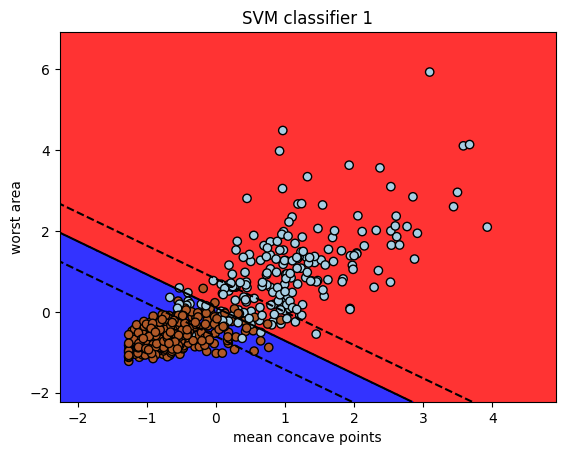

In [8]:
Z = svc1.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

Z_linear = svc1.predict(np.c_[xx.ravel(), yy.ravel()])
Z_linear = Z_linear.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors='k')
plt.contourf(xx, yy, Z_linear, cmap=ListedColormap(["#FF0000", "#0000FF"]), alpha=0.8)
plt.scatter(X_sc[:,0], X_sc[:,1], c=y, cmap=plt.cm.Paired,  edgecolors='k', label='Data Points')
plt.title("SVM classifier 1")
plt.ylabel("worst area")
plt.xlabel("mean concave points")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

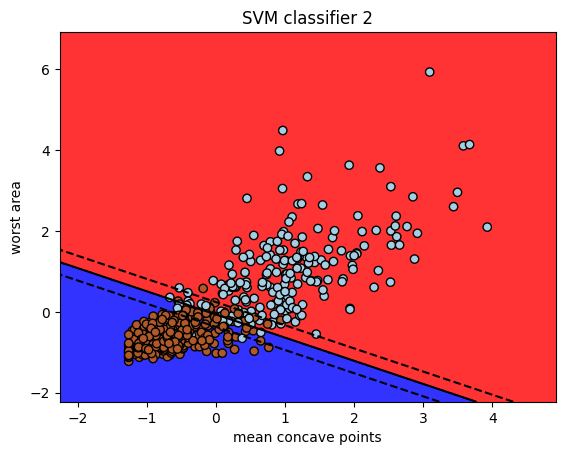

In [9]:
Z = svc2.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

Z_linear = svc2.predict(np.c_[xx.ravel(), yy.ravel()])
Z_linear = Z_linear.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors='k')
plt.contourf(xx, yy, Z_linear, cmap=ListedColormap(["#FF0000", "#0000FF"]), alpha=0.8)
plt.scatter(X_sc[:,0], X_sc[:,1], c=y, cmap=plt.cm.Paired,  edgecolors='k', label='Data Points')
plt.title("SVM classifier 2")
plt.ylabel("worst area")
plt.xlabel("mean concave points")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

In [10]:
print("Number of Support Vectors for C=0.1:", len(svc1.support_vectors_))
print("Number of Support Vectors for C=1000:", len(svc2.support_vectors_))

Number of Support Vectors for C=0.1: 129
Number of Support Vectors for C=1000: 85


In [11]:
y1_pred = svc1.predict(X_sc)
y2_pred = svc2.predict(X_sc)
f1_1 = f1_score(y, y1_pred)
f1_2 = f1_score(y, y2_pred)

print("F1 Score for classifier with C = 0.1:", round(f1_1, 4))
print("F1 Score for classifier with C = 1000:", round(f1_2, 4))

F1 Score for classifier with C = 0.1: 0.9441
F1 Score for classifier with C = 1000: 0.9512


The second classifier (C=1000) has a better F1 score which indicates that it performs better in balancing precision and recall. It also has a smaller number of Support Vectors which indicates that it has lower risk of overfitting.

We run a Grid Search for an RBF SVM.

In [12]:
param_grid = [
    {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 1, 10, 100], 'kernel': ['rbf']},
 ]
svc = SVC()
clf = GridSearchCV(svc, param_grid)
clf.fit(X_sc, y)

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [0.1, 1, 10, 100], 'gamma': [0.1, 1, 10, 100],
                          'kernel': ['rbf']}])

In [13]:
print("The best hyperparameter values are:", clf.best_params_)

The best hyperparameter values are: {'C': 1, 'gamma': 10, 'kernel': 'rbf'}


In [14]:
svc3 = SVC(C=1, gamma=10, kernel='rbf', random_state=42)

In [15]:
svc3.fit(X_sc, y)
print("Number of Support Vectors for best parameters model:", len(svc3.support_vectors_))
y3_pred = svc3.predict(X_sc)
f1_3 = f1_score(y, y3_pred)

print("F1 Score for best parameters model:", f1_3)


Number of Support Vectors for best parameters model: 197
F1 Score for best parameters model: 0.9605633802816902


The F1 score of the RBF SVM model is better than that of the linear SVM model but it has a higher number of support vectors so it may not generalize well in unseen data.

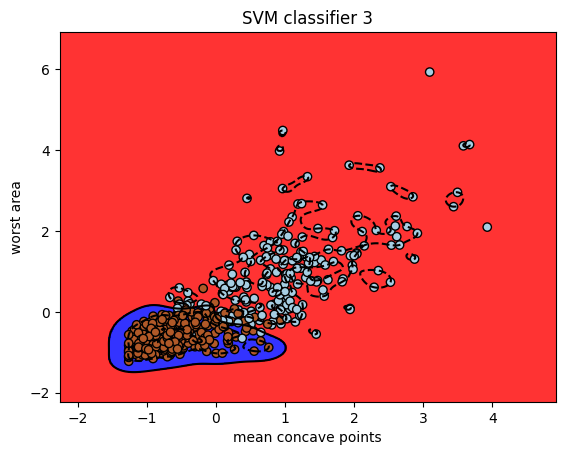

In [16]:
Z = svc3.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

Z_linear = svc3.predict(np.c_[xx.ravel(), yy.ravel()])
Z_linear = Z_linear.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors='k')
plt.contourf(xx, yy, Z_linear, cmap=ListedColormap(["#FF0000", "#0000FF"]), alpha=0.8)
plt.scatter(X_sc[:,0], X_sc[:,1], c=y, cmap=plt.cm.Paired,  edgecolors='k', label='Data Points')
plt.title("SVM classifier 3")
plt.ylabel("worst area")
plt.xlabel("mean concave points")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

From the plot, we can see that the RBF SVM predicts better the target attribute, as there are only few wrong predictions. Also the model doesn't seem to overfit so we can try it in unseen data.